# Memory managment in OpenCL

In previous lessons we have looked at straightforward ways in which memory was allocated on the host and then copied to the device for use as global memory by the kernel. In the introduction we briefly covered the five different memory spaces that are accessible to an OpenCL Program.

* Host memory
* Global memory
* Local (shared) memory
* Private memory
* Constant memory

**Host memory** is usually the largest memory space on the host, and **global memory** is the largest and slowest memory space available on the compute device. **Local** and **Constant** memory is usually placed in the small, fast caches on the compute device. **Private memory** is usually located in the registers, which are normally the fastest and smallest memory spaces available on the compute device. A programmer has some degree of control over where memory is stored during the operation of an OpenCL program. The diagram below shows what memory is available for access by both host and kernel threads (work-items) at runtime. 

<figure style="margin-left:auto; margin-right:auto; width:80%;">
    <img style="vertical-align:middle" src="../images/memory_spaces.svg">
    <figcaption style= "text-align:lower; margin:1em; float:bottom; vertical-align:bottom;">Access to memory from kernel and host threads.</figcaption>
</figure>

Kernel threads (work-items) can access *global*, *constant*, *local* and *private* memory, whereas host threads can only access *host* and *global* memory. Private memory for a kernel thread is exclusive to the kernel, meaning that no other kernel can access the same private memory. Local memory is accessible to all kernel threads in a workgroup, but not to kernel threads from another workgroup. *Global* and *Constant* memory is accessible from all kernel threads.

## Memory access from the host

From the introduction we know that Buffers are allocated on the host and they are migrated in and out of the compute device when they are needed. Here are some ways we can create Buffers and transfer memory in and out of them. 

### Buffer creation

Thus far we have been creating Buffers with the [clCreateBuffer](https://www.khronos.org/registry/OpenCL/sdk/3.0/docs/man/html/clCreateBuffer.html) function using the **CL_MEM_READ_WRITE** flag. For example, this code creates a Buffer that has read-write access from the kernel, but no additional functionality.

```C++
    cl_mem buffer_C = clCreateBuffer(context, 
                                     CL_MEM_READ_WRITE, 
                                     nbytes_C, 
                                     NULL, 
                                     &errcode);
```

#### IO permission flags

We can choose other IO flags to let the OpenCL implementation how the Buffer is to be used. This may unlock additional optimisations.

| **Allocation flag** | **Functionality** | 
| :- | :- | 
|CL_MEM_READ_WRITE| Read-write access from a kernel | 
|CL_MEM_WRITE_ONLY| Write-only access from a kernel | 
|CL_MEM_READ_ONLY | Read-only access from a kernel | 
|CL_MEM_HOST_WRITE_ONLY | Write-only access from the host | 
|CL_MEM_HOST_READ_ONLY | Read-only access from the host | 
|CL_MEM_HOST_NO_ACCESS | No access from the host | 

Common-sense rules apply in the use of these flags, for example **CL_MEM_WRITE_ONLY** is incompatible with **CL_MEM_READ_WRITE**, and behaviour is undefined if one tries to write to a buffer that has been set as **CL_MEM_READ_ONLY**.

#### Using host memory

The flag **CL_MEM_USE_HOST_PTR** allows the Buffer to use host memory as the backing store for a Buffer. One must make sure that there is enough host memory allocated to cover the memory used by the buffer and that the host memory is not de-allocated while the buffer is using it. OpenCL implementations are free to allocate caches on the compute device for temporary usage and then synchronize as required. Memory synchronization can be explicitly done using **mapping**, which will be discussed shortly. 

> I personally would **refrain** from using **CL_MEM_USE_HOST_PTR** unless special care is taken with how the memory allocation is aligned. The memory has to be specifically aligned to the type of memory access. For example you are accessing memory as **float8** vector elements, then the memory must be aligned to a (8x4=32) byte boundary. OpenCL buffers that don't use **CL_MEM_USE_HOST_PTR** are aligned properly by default. During creation of this course I found this out the hard way. Usage of **CL_MEM_USE_HOST_PTR** with unaligned memory used as **float8** resulted in a random segfault.

Similarly, the flag **CL_MEM_COPY_HOST_PTR** creates an OpenCL buffer but copies memory from a host pointer during buffer creation. After the copy finishes, the host pointer is then available for use.  

Both **CL_MEM_USE_HOST_PTR** and **CL_MEM_COPY_HOST_PTR** require a host pointer to be passed into the call to [clCreateBuffer](https://www.khronos.org/registry/OpenCL/sdk/3.0/docs/man/html/clCreateBuffer.html).

In the source code of [mat_mult_local.cpp](mat_mult_local.cpp) we demonstrate this by copying from **array_A** to make **buffer_A** by adding in the **CL_MEM_COPY_HOST_PTR** flag. 

```C++
    // Make buffer_A using array_A as the backing store
    cl_mem buffer_A = clCreateBuffer(
        context, 
        CL_MEM_READ_WRITE | CL_MEM_COPY_HOST_PTR, 
        nbytes_A, 
        (void*)array_A, 
        &errcode
    );
    h_errchk(errcode, "Creating buffer_A");
```

#### Creating buffers for fast IO

Pinned memory is host memory that cannot be paged out to swap. It enables fast and efficient Direct Memory Access (DMA) transfers from the host, however for OS health reasons the amount of pinned memory is limited to a fraction of the available memory. Normally, transfers between host and device - for example using [clEnqueueReadBuffer](https://www.khronos.org/registry/OpenCL/sdk/3.0/docs/man/html/clEnqueueReadBuffer.html) or [clEnqueueWriteBuffer](https://www.khronos.org/registry/OpenCL/sdk/3.0/docs/man/html/clEnqueueReadBuffer.html) - are synchronous, meaning they actually block until the transfer completes. The flag **CL_MEM_ALLOC_HOST_PTR** allocates pinned memory on the host as the backing store for the OpenCL buffer. This also enables asynchronous transfers so that IO movement can occur at the same time as compute. In [mat_mult_local.cpp](mat_mult_local.cpp) we create **buffer_C** from pinned host memory by adding the **CL_MEM_ALLOC_HOST_PTR** flag.

```C++
    // Allocate buffer C from pinned host memory
    cl_mem buffer_C = clCreateBuffer(
        context, 
        CL_MEM_READ_WRITE | CL_MEM_ALLOC_HOST_PTR, 
        nbytes_C, 
        NULL, 
        &errcode
    );
    h_errchk(errcode, "Creating buffer_C");
```

Both **CL_MEM_COPY_HOST_PTR** and **CL_MEM_ALLOC_HOST_PTR** may be used together. Only **CL_MEM_USE_HOST_PTR** and **CL_MEM_ALLOC_HOST_PTR** are mutually exclusive.

### Explicit memory movement

The OpenCL 1.2 and earlier standards require explicit memory transfers between OpenCL buffer and host. You have the option of copying either contiguous or rectangular regions of allocated memory. By rectangular I mean that if the memory allocation is interpreted as being **folded into a multidimensional array** then a rectangular copy would copy a rectangular region of that array.

#### Contiguous copies

<figure style="margin-left:auto; margin-right:auto; width:80%;">
    <img style="vertical-align:middle" src="../images/contiguous_memory_copy.svg">
    <figcaption style= "text-align:lower; margin:1em; float:bottom; vertical-align:bottom;">Contiguous memory copy.</figcaption>
</figure>

If you need to copy contiguous chunks of memory, then [clEnqueueWriteBuffer](https://www.khronos.org/registry/OpenCL/sdk/3.0/docs/man/html/clEnqueueWriteBuffer.html) **writes to** the OpenCL buffer from host memory and [clEnqueueReadBuffer](https://www.khronos.org/registry/OpenCL/sdk/3.0/docs/man/html/clEnqueueReadBuffer.html) reads **from** a buffer to host memory. The function [clEnqueueCopyBuffer](https://www.khronos.org/registry/OpenCL/sdk/3.0/docs/man/html/clEnqueueCopyBuffer.html) performs a copy of contiguous memory between two OpenCL buffers **within the same OpenCL context**. All three options have the ability to specify a starting offset (in bytes) within the OpenCL buffer, and [clEnqueueCopyBuffer](https://www.khronos.org/registry/OpenCL/sdk/3.0/docs/man/html/clEnqueueReadBuffer.html) has the additional capability to specify the offset for the destination buffer.

#### Rectangular copies

Sometimes a contiguous copy is not sufficient, particularly when you treat the the allocation as a multi-dimensional array and wish to copy a rectangular region. The functions [clEnqueueWriteBufferRect](https://www.khronos.org/registry/OpenCL/sdk/3.0/docs/man/html/clEnqueueWriteBufferRect.html) **writes** a 3D rectangular region to the OpenCL buffer from host memory and [clEnqueueReadBufferRect](https://www.khronos.org/registry/OpenCL/sdk/3.0/docs/man/html/clEnqueueReadBufferRect.html) **reads** a 3D rectangular region from host memory. 

<figure style="margin-left:auto; margin-right:auto; width:80%;">
    <img style="vertical-align:middle" src="../images/rectangular_memory_copy.svg">
    <figcaption style= "text-align:lower; margin:1em; float:bottom; vertical-align:bottom;">Rectangular memory copy.</figcaption>
</figure>

I found the documentation on these functions quite confusing to comprehend, particularly in translating from one indexing system (i.e row-major) to another. It is important to remember that in the documentation the word **"row"**  is the dimension along which memory is contiguous. **Row pitch** is the number of bytes along a row of **the memory allocation**, and **slice pitch** is the number of bytes in a slice of **the memory allocation**. Within the memory allocation a **region** is selected for the copy, it is of size (nbytes along the row, nrows, nslices). If you are only doing a 2D copy then use a value of 1 for **nslices**. The copy can be located at an **origin** within the memory allocations, this has units of (offset in bytes along a row, row id, slice id). Row id and slice id's are indices starting at 0. 

Rectangular copies result in more efficient copies than enqueuing numerous calls to the contiguous memory copy functions to cover the same region. In similar fashion, the function  [clEnqueueCopyBufferRect](https://www.khronos.org/registry/OpenCL/sdk/3.0/docs/man/html/clEnqueueCopyBufferRect.html) copies 3D rectangular regions between OpenCL buffers. In [mat_mult_local.cpp](mat_mult_local.cpp) we use a rectangular copy to copy memory from **array_B** to **buffer_B**.

```C++
    // Do a rectangular copy from host to memory in buffer_B
    
    // B is of size (N1_A, N1_C)
    // Offset is in bytes, row_id and slice_id are indices
    size_t offset=0, row_id=0, slice_id = 0;
    
    // Make up the origin for host and buffer
    const size_t buffer_origin[] = {offset, row_id, slice_id};
    const size_t host_origin[] = {offset, row_id, slice_id};
    
    // Length of a row (in bytes)
    size_t buffer_row_pitch = N1_C * sizeof(cl_float); 
    size_t host_row_pitch = buffer_row_pitch;
    
    // Number of bytes in a slice 
    size_t buffer_slice_pitch = N1_A * buffer_row_pitch;
    size_t host_slice_pitch = N1_A * host_row_pitch;        
        
    /// Size of the region to copy, of course we only copy 1 slice
    size_t nrows = N1_A, nslices = 1;
    const size_t region[] = {buffer_row_pitch, nrows, nslices};
     
    // Enqueue the rectangular copy
    h_errchk(
        clEnqueueWriteBufferRect(
            command_queue,
            buffer_B,
            CL_TRUE,
            buffer_origin,
            host_origin,
            region,
            buffer_row_pitch,
            buffer_slice_pitch,
            host_row_pitch,
            host_slice_pitch,
            array_B,
            0,
            NULL,
            NULL
        ),
        "Rectangular copy to buffer_B from the host"
    );
```


#### Buffer mapping

With the contiguous and rectangular copies there are two memory spaces in use, one for the OpenCL buffer and one for the host. It is possible to map (or make available) an OpenCL buffer as an allocation of host memory, thus avoiding the explicit memory transfer. This approach can be particularly beneficial when a CPU or integrated GPU is employed, as the memory for the buffer is already on the host and no actual transfer from the device is needed. Buffer mapping can be useful for GPU's as well. With buffer mapping the OpenCL implementation has the opportunity to optimise transfers and synchronisation between OpenCL buffer and host. The command [clEnqueueMapBuffer](https://www.khronos.org/registry/OpenCL/sdk/3.0/docs/man/html/clEnqueueMapBuffer.html) maps an OpenCL buffer into host memory. It uses the following mapping flags:

| **Mapping flag** | **Functionality** | 
| :- | :- | 
|CL_MAP_READ | The buffer is being mapped for reading | 
|CL_MAP_WRITE | The buffer is being mapped for writing | 
|CL_MAP_WRITE_INVALIDATE_REGION | The buffer is going to be written by the host soon and we don't need to care what is in it (potential source of optimisation).

When a buffer is mapped to the host access to the buffer from an OpenCL kernel is considered to be undefined behaviour. The [clEnqueueUnmapMemObject](https://www.khronos.org/registry/OpenCL/sdk/3.0/docs/man/html/clEnqueueUnmapMemObject.html) function unmaps the memory from the host and makes it available to kernels again. In [mat_mult_local.cpp](mat_mult_local.cpp) we map buffer_C back to the host and make the memory available to the host as **array_C**. Then we write **array_C** to disk before unmapping **buffer_C**.

```C++
    // Map the buffer_C back to the host so we can write it to disk
    cl_float* array_C = (cl_float*)clEnqueueMapBuffer(
        command_queue,
        buffer_C,
        CL_TRUE,
        CL_MAP_READ,
        0,
        nbytes_C,
        0,
        NULL,
        NULL,
        &errcode
    );
    h_errchk(errcode, "Mapping matrix C from device to host");
    
    // Write out the result to file
    h_write_binary(array_C, "array_C.dat", nbytes_C);

    // Unmap buffer_C so we can release it
    h_errchk(
        clEnqueueUnmapMemObject(
            command_queue,
            buffer_C,
            (void*)array_C,
            0,
            NULL,
            NULL
        ),
        "Unmapping array C"
    );
```


#### Initialisation

Sometimes you need to fill or initialise the contents of a buffer. The [clEnqueueFillBuffer](https://www.khronos.org/registry/OpenCL/sdk/3.0/docs/man/html/clEnqueueFillBuffer.html) command fills buffers with a user-defined pattern such as 0, for example.

## Running the application

In [4]:
import numpy as np
from matplotlib import pyplot as plt

%matplotlib widget

# A is of size (NROWS_C, NCOLS_A)
# B is of size (NCOLS_A, NCOLS_C)    
# C is of size (NROWS_C, NCOLS_C)

NCOLS_A = 256
NROWS_C = 520
NCOLS_C = 1032

# Data type
dtype = np.float32

# Make up the arrays A, B, and C
A = np.random.random(size = (NROWS_C, NCOLS_A)).astype(dtype)
B = np.random.random(size = (NCOLS_A, NCOLS_C)).astype(dtype)

# Make up the answer
C = np.matmul(A, B, dtype = dtype)

# Write out the arrays as binary files
A.tofile("array_A.dat")
B.tofile("array_B.dat")

In [2]:
!make clean; make; ./mat_mult_local.exe

rm -r *.exe
g++ -g -O2 -fopenmp  -I/usr/include -I../include -L/usr/lib64 mat_mult_local.cpp\
	-o mat_mult_local.exe -lOpenCL -lomp
In file included from mat_mult_local.cpp:16:0:
../include/cl_helper.hpp: In function ‘_cl_command_queue** h_create_command_queues(_cl_device_id**, _cl_context**, cl_uint, cl_uint, cl_bool, cl_bool)’:
../include/cl_helper.hpp:315:9: warning: ‘_cl_command_queue* clCreateCommandQueue(cl_context, cl_device_id, cl_command_queue_properties, cl_int*)’ is deprecated [-Wdeprecated-declarations]
         );
         ^
In file included from /usr/include/CL/opencl.h:24:0,
                 from ../include/cl_helper.hpp:15,
                 from mat_mult_local.cpp:16:
/usr/include/CL/cl.h:1906:1: note: declared here
 clCreateCommandQueue(cl_context                     context,
 ^~~~~~~~~~~~~~~~~~~~
g++ -g -O2 -fopenmp  -I/usr/include -I../include -L/usr/lib64 mat_mult_local_transpose_vector.cpp\
	-o mat_mult_local_transpose_vector.exe -lOpenCL -lomp
In file included fro

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
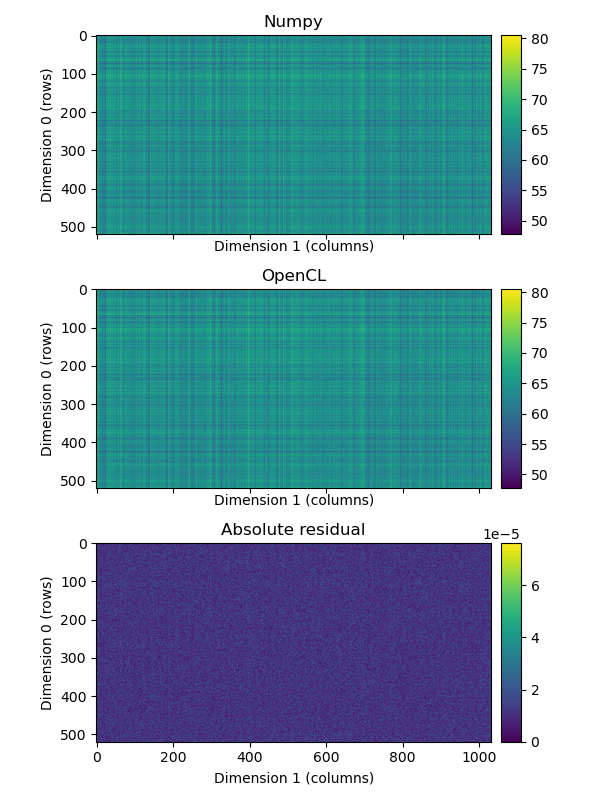

In [3]:
# Import axes machinery
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Read in the output from OpenCL
C_ocl = np.fromfile("array_C.dat", dtype=dtype).reshape((NROWS_C, NCOLS_C))

# Make plots
fig, axes = plt.subplots(3, 1, figsize=(6,8), sharex=True, sharey=True)

# Data to plot
data = [C, C_ocl, np.abs(C-C_ocl)]

# Labels to plot
labels = ["Numpy", "OpenCL", "Absolute residual"]

for n, value in enumerate(data):
    # Plot the graph
    ax = axes[n]
    im = ax.imshow(value)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)

    # Set labels on things
    ax.set_xlabel("Dimension 1 (columns)")
    ax.set_ylabel("Dimension 0 (rows)")
    ax.set_title(labels[n])

    # Put a color bar on the plot
    plt.colorbar(mappable=im, cax=cax)

fig.tight_layout()
plt.show()

## Memory control and access from kernels

Kernels have access to the following memory spaces:

* Global memory
* Local (shared) memory
* Private memory
* Constant memory

[This link](https://www.khronos.org/registry/OpenCL/sdk/3.0/docs/man/html/addressSpaceQualifiers.html) provides more information on the memory spaces. Variables defined in kernel sources can be (and sometimes must be) qualified as to which memory space they belong to. There is, however a myriad of rules to navigate, as we shall see below.

### Global address space

Allocations of memory in the **global address space** are qualified by an additional **\_\_global** or **global** qualifier in front of the variable type when it is declared (both in function preambles as well as in the function body). Both are valid and you don't need to put the **\_\_** in front of **global**. I'm just doing it here so Jupyter syntax highlighting picks up the qualifier. Pointers to buffer allocations passed in to kernels **always** need to have the **\_\_global** qualifier. We see this in the kernel definition for **mat_mult_local** in [kernels_mat_mult.c](kernels_mat_mult.c).

```C
// kernels_mat_mult.c source

// Matrix multiply kernel that uses local memory
__kernel void mat_mult_local (
                        __global float* A, 
                        __global float* B, 
                        __global float* C,
                        __local  float* shared_A,
                        __local  float* shared_B,
                        unsigned int N1_A, 
                        unsigned int N0_C,
                        unsigned int N1_C) { 
```

It is interesting that inside the kernel I can use a different variable type for the pointers to interpret the memory allocation **as another type**. For example we can change the pointer type in the kernel to **float8\*** and interpret the input arrays as elements of type **float8**

```C
__kernel void mat_mult_local (
                        __global float8* A, 
                        __global float8* B, 
                        __global float* C,
                        __local  float8* shared_A,
                        __local  float8* shared_B,
                        unsigned int N1_A, 
                        unsigned int N0_C,
                        unsigned int N1_C) { 
```

Of course we need to ensure that we don't go off the end of the array, and that the number of floats allocated is a multiple of eight. 

Variables in the global address space can also be declared outside kernel functions if the **\_\_opencl_c_program_scope_global_variables** macro is defined.

```C
// kernels_mat_mult.c source

// Example of a global variable
#ifdef __opencl_c_program_scope_global_variables
__global int a_g = 2; 
__global float b_g[2] = {2.0,1.0}; 
#endif

// standard matrix multiply kernel 
__kernel void mat_mult_local (__global float* A,... 
```

If **a_g** and **b_g** are defined, then the variables are available to every kernel that runs in the program on the compute device.

### Constant address space

The constant address space is usually located in a fast cache and is defined by the **\_\_constant** or **constant** address qualifer. This makes it ideal for storing small (~16-128 KB) allocations of memory that must be accessible to all kernels (coefficients for example). The **clinfo** command shows you how much constant memory is available on each device.

In the source file [kernels_mat_mult.c](kernels_mat_mult.c) we define a couple of variables in the constant memory space

```C
// Example of constant memory
__constant float pi = 3.1415;
__constant float coeffs[] = {1.0, -2.0, 1.0};
```

Then we can use the constant variable **pi** within the **mat_mult_local** kernel as follows:
```C
// Scratch variable whose allocation uses constant memory
float temp=0.0*pi; 
```

### Local address space

Memory in the **local** address space is local to the workgroup, meaning every work-item in the workgroup can access the memory, but work-items in another workgroup cannot. Local memory is specified with the **\_\_local** or **local** qualifier in front of the variable type at declaration (which happens either in a kernel function or in the kernel function preamble). Local memory is often backed by fast caches on the compute device and **might** provide a speed boost by virtue of being in close proximity (in terms of latency and bandwidth) to the processor cores. Having said that, devices and OpenCL implementations are very good at caching global memory to fast caches, so you may or may not see a performance boost by using local memory.

There are two ways to allocate local memory, **static** and **dynamic** allocation:

#### Static allocation

Static allocations of local memory happen within the body of the kernel function. For example, in the code [kernels_mat_mult.c](kernels_mat_mult.c) we allocate an array of 10 floats

```C++
    // kernels_mat_mult.c source
    // Make a local scratch array for demonstration purposes
    // (not actually used)
    __local float scratch[10];
```

Static allocations of local memory must happen in the outermost scope of the function, meaning every work item has to execute the allocation. Some implementations will not let you hide the allocation in a code block, and you also cannot allocate local memory within functions that are called from kernels.

#### Dynamic allocation

This is my preferred way of allocating local memory. Allocations to local memory are brought into a kernel as an argument with the **\_\_local** (or **local**) address qualifier, as can be seen with the **shared_A** and **shared_B** local memory allocations in the **mat_mult** kernel, in [kernels_mat_mult.c](kernels_mat_mult.c).

```C++
// kernels_mat_mult.c source

// Local memory matrix multiply kernel 
__kernel void mat_mult (__global float* A, 
                        __global float* B, 
                        __global float* C,
                        __local  float* shared_A,
                        __local  float* shared_B,
                        unsigned int N1_A, 
                        unsigned int N0_C,
                        unsigned int N1_C) { 
```

The amount of local memory to allocated is specified at runtime by the [clSetKernelArg](https://www.khronos.org/registry/OpenCL/sdk/3.0/docs/man/html/clSetKernelArg.html) function. In the [mat_mult_local.cpp](mat_mult_local.cpp) sources we specify how much memory is to be allocated for **shared_A** and **shared_B**. Notice that the last pointer argument is NULL, whereas it usually points to a buffer or variable.

```C++
    // mat_mult_local.cpp source

    // Set shared memory in argument 3
    // Local size is going to be (local_size[0], N1_A)
    h_errchk(
        clSetKernelArg(kernel, 3, local_size[0]*N1_A*sizeof(cl_float), NULL ),
        "setting kernel argument 3"
    );
    // Local size is going to be (local_size[1], N1_A)
    h_errchk(
        clSetKernelArg(kernel, 4, local_size[1]*N1_A*sizeof(cl_float), NULL ),
        "setting kernel argument 3"
    );
```


#### Example, matrix multiplication with local memory

There is an opportunity to employ local memory within the matrix multiplication example. A workgroup is of size **(L0, L1)**. Every work item in a row of a workgroup needs access to the same row of matrix A, and every column in the workgroup needs access to the same column of matrix B. If the workgroup prefetches these rows and columns into local fast caches, then there is potential to save time on fetches from global memory. Using the dynamic memory allocation method above we allocate two local memory spaces **shared_A** and **shared_B**, both have a row length of **N1_A** elements. The memory space **shared_A** has **L0** rows, whereas the space **shared_B** has **L1** rows.

<figure style="margin-left:auto; margin-right:auto; width:100%;">
    <img style="vertical-align:middle" src="../images/matrix_multiplication_shmem.svg">
    <figcaption style= "text-align:lower; margin:1em; float:bottom; vertical-align:bottom;">Using local memory in matrix multiplication.</figcaption>
</figure>

Each local memory space is divided into blocks of elements along dimension 1 so that every work-item can be responsible for filling a portion of the shared spaces. There are **L1** blocks (along dimension 1) to copy for **shared_A** and **L0** blocks (along dimension 1) to copy for **shared_B**. The kernel code for filling the shared memory is below.

```C++

    // kernels_mat_mult.c source

    // Get the start1 and end1 lengths to fill a block
    get_start_end(L1, N1_A, s1, &start1, &end1);
    // Fill shared_A with the rows of A
    if (i0<N0_C) {
        for (size_t n=start1; n<end1; n++) {
            shared_A[s0*N1_A+n]=A[i0*N1_A+n]; 
        }
    }   
    
    // Get the start0 and end0 lengths
    get_start_end(L0, N1_A, s0, &start0, &end0);
    // Fill the columns of shared with B
    if (i1<N1_C) {
        for (size_t n=start0; n<end0; n++) {
            shared_B[s1*N1_A+n]=B[n*N1_C+i1]; 
        }
    }
    
    // Enqueue a local barrier to make sure shared memory is filled
    barrier(CLK_LOCAL_MEM_FENCE);
```

We use a kernel function called **get_start_end** to get the start and end indices of a block along dimension 1 of shared memory. Then we use two loops to fill the shared memory from matrices A and B. 

##### **Work item synchronisation**

Some work items will finish the copy before others, however they need to **wait** until that all work items have finished the copy before local memory allocations become useful. A call to the inbuilt OpenCL kernel function **barrier** with the **CLK_LOCAL_MEM_FENCE** ensures that local memory is consistent amongst the workgroup before proceeding.

```C++

    // kernels_mat_mult.c source
    
    // Enqueue a local barrier to make sure shared memory is filled
    barrier(CLK_LOCAL_MEM_FENCE);
```

If you also need to ensure global memory is consistent at a barrier within a workgroup you can use the **CLK_GLOBAL_MEM_FENCE** flag with the **barrier** call.

After the barrier, local memory is now populated and available for all work-items. While performing the matrix operation we draw from the local memory allocations instead of global memory 

```C++
    // Guard mechanism to make sure we do not go
    // outside the boundaries of matrix C
    if ((i0<N0_C) && (i1<N1_C)) {
        
        // Loop over columns of A and rows of B 
        for (size_t n=0; n<N1_A; n++) {
            
            // A is of size (N0_C, N1_A)
            // B is of size (N1_A, N1_C)
            // C is of size (N0_C, N1_C)
            
            // Loop across row i0 of A
            // and down column i1 of B
            temp+=shared_A[s0*N1_A+n]*shared_B[s1*N1_A+n]; 
        } 
        // Number of rows in C is same as number of rows in A
        C[i0*N1_C+i1]=temp;
    }
```

The matrix multiplication code in [mat_mult_local.cpp](mat_mult_local.cpp) is using the local memory implementation. Feel free to run the example again to verify that it works!

### Private memory

Private memory is the default storage space for variables created inside a running kernel. This memory is only available to the work item that allocates it. One does not need to use the **__private** (or **private**) qualifier as variables created in kernels are **private** by default. For example, in the **mat_mult** kernel in [kernels_mat_mult.c](kernels_mat_mult.c) we declare a private variable **temp** for use in the matrix dot products.

```C++
    // Scratch variable whose allocation uses constant memory pi
    float temp=0.0*pi;
```

Private memory is usually allocated from the fastest register memory on the device, but the  amount of available register memory is very small. If a kernel uses more register memory than there are variables, then register memory can spill over into global memory at the cost of performance.



### Generic addresses

Generic address spaces is an OpenCL 2.0 feature that enables functions called from kernels to accept pointer arguments from private, local, and global address spaces without having to qualify the address space they come from. Generic addresses are become available if the OpenCL implementation is 2.0+ compliant and the compiler option **"-cl-std=CL2.0"** is added to the compiler options at program compilation. Then, the following macro should be defined by the preprocessor.

```C++
__opencl_c_generic_address_space
```

## Shared virtual memory (SVM)

Shared Virtual Memory (SVM) is a way to blur or even erase the boundary between host memory and global device memory. Sometimes algorithms can benefit when both host and device share access to the same memory. Compute device architectures such as System On Chip (SOC), where an integrated GPU uses host memory, is served well by shared virtual memory. This feature is only available on OpenCL 2.0+ implementations, and optionally available on OpenCL 3.0+ implementations.

### Types of shared virtual memory

There are three main types of shared virtual memory (SVM):

* Coarse-grained buffer SVM
* Fine-grained buffer SVM
* Fine-grained system SVM

**Coarse-grained buffer SVM** is the most basic level of SVM support and the only one required by the OpenCL 2.0 standard. It isn't much different from standard OpenCL buffers. The only difference I can see is that it enables one to allocate and de-allocate memory on the host using special SVM functions [clSVMAlloc](https://www.khronos.org/registry/OpenCL/sdk/3.0/docs/man/html/clSVMAlloc.html) and [clSVMFree](https://www.khronos.org/registry/OpenCL/sdk/3.0/docs/man/html/clSVMFree.html), and then the ability to use the allocated pointer in a kernel invocation instead of an OpenCL buffer. There may be synchronisation between host and device, however the allocation must still be mapped back to the host for host access and then un-mapped when host access is no longer required.

**Fine-grained buffer SVM** removes the requirement to map and unmap memory, but it still needs the special SVM functions [clSVMAlloc](https://www.khronos.org/registry/OpenCL/sdk/3.0/docs/man/html/clSVMAlloc.html) and [clSVMFree](https://www.khronos.org/registry/OpenCL/sdk/3.0/docs/man/html/clSVMFree.html) to allocate and de-allocate shared memory. At runtime the code must notify the kernel of any SVM pointers that are to be used, either directly as kernel arguments or indirectly used (i.e through pointers in data structures accessed by the kernel). This can be rather painful. Unlike coarse-grained SVM, both host and device can access the allocation at the **same time**. Consistency between host and device is guaranteed if host and device are accessing different bytes in the allocation. If there is a need for host and device to read what the other has written, then memory can be explicitly synchronised by waiting for enqueued commands to finish. If host and device must read and update the **same bytes in the allocation**, then atomic data types (if supported) and special synchronisation functions can be used to maintain coherency.

**Fine-grained system SVM** further removes the requirement to use [clSVMAlloc](https://www.khronos.org/registry/OpenCL/sdk/3.0/docs/man/html/clSVMAlloc.html) and [clSVMFree](https://www.khronos.org/registry/OpenCL/sdk/3.0/docs/man/html/clSVMFree.html) to allocate and de-allocate shared memory. System functions (such as **malloc**) allocate memory on the host, and the associated pointer is available for use in kernels. Only pointers directly used by the kernel must be passed in as kernel arguments. Pointers used indirectly can be accessed without having to notify the kernel of their existence. As with fine-grained buffer SVM, if host and device must read and update the **same bytes in the allocation**, then atomic data types (if supported) and special synchronisation functions can be used to maintain coherency.


#### Checking to see what kind of SVM your system supports



#### Coarse-grained SVM


In [12]:
!make; ./mat_mult_coarse_buffer_svm.exe -gpu 1

make: Nothing to be done for 'all'.
	               name: NVIDIA GeForce RTX 3060 
	 global memory size: 12635 MB
	    max buffer size: 3158 MB
	     max local size: (1024,1024,64)
	     max work-items: 1024


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
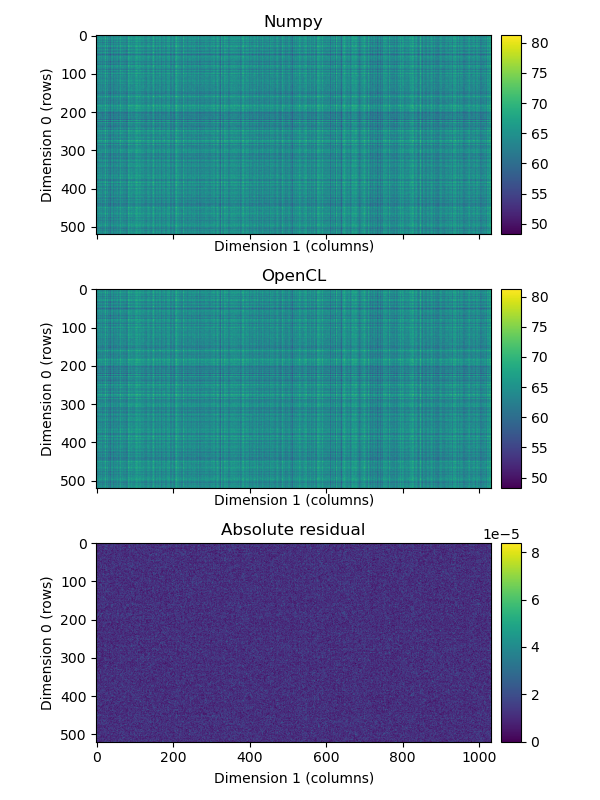

In [13]:
# Import axes machinery
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Read in the output from OpenCL
C_ocl = np.fromfile("array_C.dat", dtype=dtype).reshape((NROWS_C, NCOLS_C))

# Make plots
fig, axes = plt.subplots(3, 1, figsize=(6,8), sharex=True, sharey=True)

# Data to plot
data = [C, C_ocl, np.abs(C-C_ocl)]

# Labels to plot
labels = ["Numpy", "OpenCL", "Absolute residual"]

for n, value in enumerate(data):
    # Plot the graph
    ax = axes[n]
    im = ax.imshow(value)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)

    # Set labels on things
    ax.set_xlabel("Dimension 1 (columns)")
    ax.set_ylabel("Dimension 0 (rows)")
    ax.set_title(labels[n])

    # Put a color bar on the plot
    plt.colorbar(mappable=im, cax=cax)

fig.tight_layout()
plt.show()

#### Fine-grained buffer SVM

#### Fine-grained system SVM